# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

[-0.11465911  0.10692893 -0.28343096  0.06346946  0.2178054  -0.05083128
 -0.04885855  0.26296542 -0.29651723  0.26953479]
[-0.3841939  -0.16260586 -0.55296575 -0.20606533 -0.05172939 -0.32036607
 -0.31839334 -0.00656937 -0.56605202  0.        ]
loss: 2.348167
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
因为经过loss函数是-log(exp(f(yi)/sigma(exp(f(j)))，而每一个计算出的f值是差不多相等的（真实的计算出的scores应该要大，因此最后这个值应当要越小越好）

In [49]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -5.136931 analytic: -5.136931, relative error: 1.786734e-09
numerical: -1.288391 analytic: -1.288391, relative error: 2.305799e-08
numerical: -0.603485 analytic: -0.603485, relative error: 5.003434e-08
numerical: 1.901612 analytic: 1.901612, relative error: 1.461872e-08
numerical: 0.507807 analytic: 0.507807, relative error: 1.156796e-09
numerical: 2.214400 analytic: 2.214400, relative error: 2.324944e-08
numerical: -0.073675 analytic: -0.073675, relative error: 1.086519e-07
numerical: -1.103983 analytic: -1.103983, relative error: 2.748636e-08
numerical: -0.266338 analytic: -0.266338, relative error: 1.841867e-07
numerical: -0.721815 analytic: -0.721816, relative error: 6.390169e-08
numerical: 2.053716 analytic: 2.053716, relative error: 3.709868e-08
numerical: 2.967011 analytic: 2.967011, relative error: 1.261455e-08
numerical: -4.484109 analytic: -4.484109, relative error: 1.417037e-08
numerical: -1.668744 analytic: -1.668744, relative error: 2.616724e-09
numerical: 0.017

In [58]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.387697e+00 computed in 0.114983s
[[ -2.57219036e+00  -2.53763038e+00   6.21872809e-01 ...,  -1.90924948e+00
   -1.29126542e+00   5.79665565e-01]
 [ -3.30478014e+00  -2.56072086e+00   3.21974986e-01 ...,  -2.52695505e+00
   -2.62560970e+00   3.77190022e-01]
 [ -4.95016915e+00  -2.59677707e+00   7.16372797e-01 ...,  -2.70694980e+00
   -4.57120579e+00  -2.23180925e-01]
 ..., 
 [ -2.04113884e+00  -1.11862608e+00   3.77465572e-01 ...,  -1.68267839e+00
    1.80483231e+00   3.01995027e+00]
 [ -3.38528543e+00  -1.43862625e+00   8.08754798e-01 ...,  -2.79492378e-01
   -9.65087478e-02   2.86170212e+00]
 [ -1.29908750e-02  -7.09525142e-03  -9.77450906e-03 ...,  -1.25943218e-02
   -7.34402325e-04   4.15395405e-02]]
vectorized loss: 2.387697e+00 computed in 0.081278s
Loss difference: 0.000000
Gradient difference: 0.000000


In [62]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for i in learning_rates:
    for j in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=i, reg=j,
                      num_iters=1000, verbose=True) #这个输出是一个一维数组，长度是num_iter，即每次迭代的loss大小
        y_train_pred = softmax.predict(X_train) 
        train_accuracy = np.mean(y_train == y_train_pred) #计算出训练集的准确度
        print('training accuracy: %f' % train_accuracy)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred) #计算出验证集的准确度
        print('validation accuracy: %f' % validation_accuracy)
        results[(i, j)] = (train_accuracy, validation_accuracy) #把结果保存到map里面
        if validation_accuracy > best_val:
            best_val = validation_accuracy #max(best_val, validation_accuracy)
            best_softmax = softmax
        
print(results)       


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 389.321331
iteration 100 / 1000: loss 234.801772
iteration 200 / 1000: loss 142.945978
iteration 300 / 1000: loss 87.121031
iteration 400 / 1000: loss 53.597415
iteration 500 / 1000: loss 33.052345
iteration 600 / 1000: loss 20.787986
iteration 700 / 1000: loss 13.426621
iteration 800 / 1000: loss 8.868321
iteration 900 / 1000: loss 6.225084
training accuracy: 0.338469
validation accuracy: 0.346000
iteration 0 / 1000: loss 783.254595
iteration 100 / 1000: loss 287.351749
iteration 200 / 1000: loss 106.492524
iteration 300 / 1000: loss 40.272189
iteration 400 / 1000: loss 15.970648
iteration 500 / 1000: loss 7.191927
iteration 600 / 1000: loss 4.022105
iteration 700 / 1000: loss 2.733836
iteration 800 / 1000: loss 2.273230
iteration 900 / 1000: loss 2.156589
training accuracy: 0.325776
validation accuracy: 0.348000
iteration 0 / 1000: loss 388.235786
iteration 100 / 1000: loss 32.555750
iteration 200 / 1000: loss 4.528614
iteration 300 / 1000: loss 2.279267
iter

In [63]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.344000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

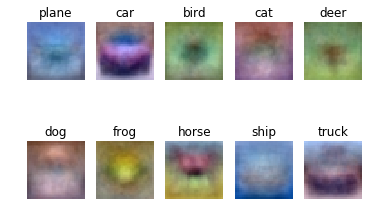

In [64]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])